這段程式碼是在**使用多項式回歸（Polynomial Regression）與正規方程（Normal Equation）來擬合一組帶有雜訊的二次函數數據點**。

簡單來說，它試圖從一堆亂掉的點中，找出一條最接近這些點的數學曲線。

### 核心三步驟：

1. **生成數據**：在  的基礎上加上隨機雜訊。
2. **數學求解**：利用線性代數矩陣運算（不靠 AI 訓練，而是直接用公式解）算出多項式的係數 。
3. **結果呈現**：把學到的紅線、原始的綠線與藍色數據點畫出來對比。

多項式階數 K = 4
學習到的權重 w = 
[-0.0187441   0.0571835   0.95727372 -0.06493488  0.1185619 ]


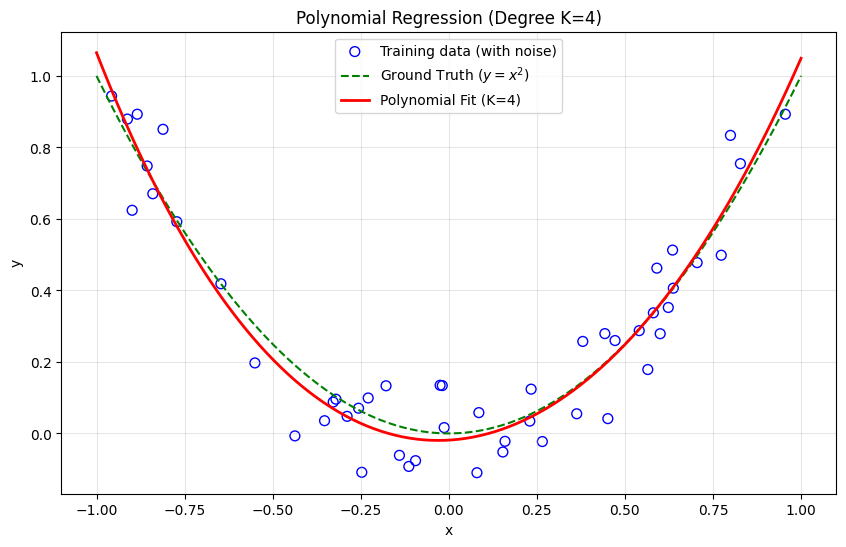

In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 設定隨機種子，確保雜訊生成結果可重現
# np.random.seed(564)

def sample(n_samples, std=0.1):
    """
    生成帶有高斯雜訊的二次函數樣本
    n_samples: 欲生成的樣本數量
    std: 雜訊標準差，控制數據偏離真實曲線的程度
    """
    # 在 -1 到 1 之間均勻採樣，並排序以利繪圖
    x = np.sort(np.random.uniform(-1, 1, n_samples))

    # 目標值 y = x^2 + ε (ε ~ N(0, std^2))
    y = x ** 2 + np.random.normal(scale=std, size=x.shape)
    return x, y

# 1. 生成 50 筆訓練數據
n_samples = 50
x, y = sample(n_samples)

# 設定多項式的階數 (Degree)，可以設定不同階數，
K = 4

# 2. 構造設計矩陣 (Design Matrix) Φ
# 包含 x^0, x^1, ..., x^K 等特徵項
# 每一列 (Row) 代表一個樣本，每一行 (Column) 代表一個特徵次方
X = np.array([np.power(x, k) for k in range(K+1)]).transpose()

# 3. 使用正規方程 (Normal Equation) 求解權重向量 w
# 解析解公式：w = (X^T * X)^-1 * X^T * y
# 這能直接計算出使殘差平方和最小化的權重，無需迭代優化
XT = X.transpose()
w = np.linalg.inv(XT @ X) @ (XT @ y)

print(f"多項式階數 K = {K}")
print(f"學習到的權重 w = \n{w}")

# --- 預測與視覺化 ---

# 生成用於繪圖的連續點 (100 個點，範圍 -1 到 1)
x_test = np.linspace(-1, 1, 100)
# 真實的二次函數曲線 (Ground Truth)
y_true = x_test ** 2

# 4. 計算模型預測值 (計算 y = Σ w_j * x^j)
y_predict = np.zeros_like(x_test)
for j, wj in enumerate(w):
    y_predict += wj * np.power(x_test, j)

# 繪圖呈現
plt.figure(figsize=(10, 6))
plt.scatter(x, y, facecolor="none", edgecolor="b", s=50, label="Training data (with noise)") # 藍色採樣點
plt.plot(x_test, y_true, c="g", linestyle="--", label=r"Ground Truth ($y=x^2$)")              # 綠色虛線：原始函數
plt.plot(x_test, y_predict, c="r", linewidth=2, label=f"Polynomial Fit (K={K})")           # 紅色實線：擬合結果

plt.title(f"Polynomial Regression (Degree K={K})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

*   當 $K$（多項式階數）太低時，模型無法捕捉數據特徵（欠擬合）
*   當 $K$ 太高時，模型會連雜訊都想擬合進去，導致曲線劇烈震盪（過擬合）
我們可以修改程式碼，讓它一次顯示 $K=1$（欠擬合）、$K=2$（恰當）、$K=15$（過擬合） 三種情況：

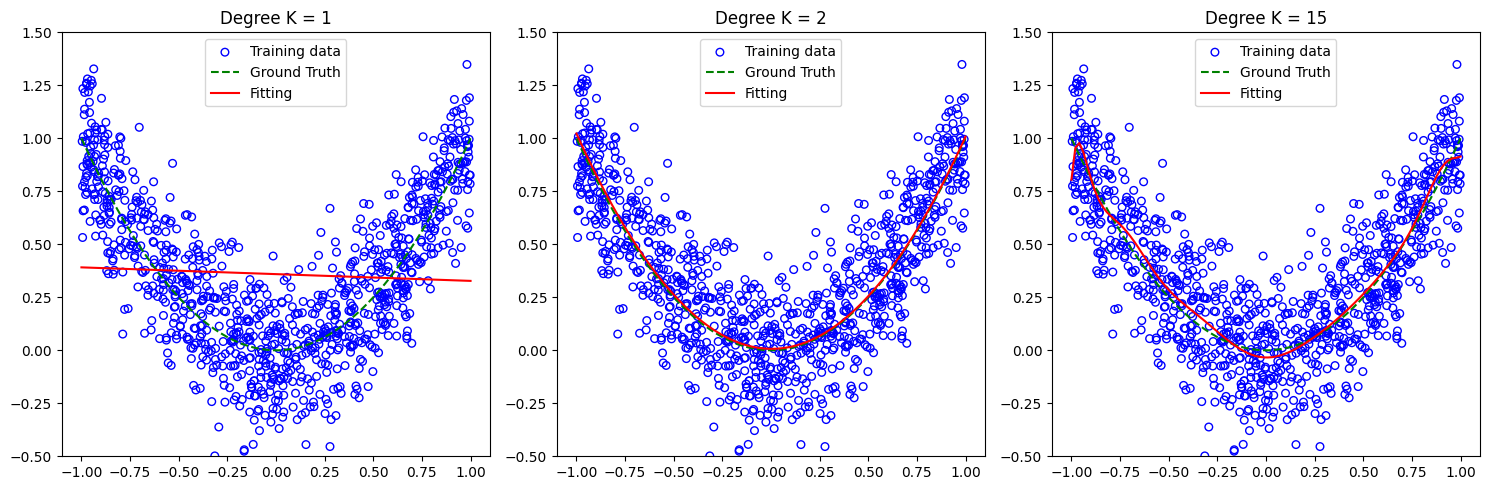

In [34]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(564)

def sample(n_samples=100, std=0.2): # 減少樣本量，過擬合現象會更明顯
    x = np.sort(np.random.uniform(-1, 1, n_samples))
    y = x ** 2 + np.random.normal(scale=std, size=x.shape)
    return x, y

x, y = sample()
x_test = np.linspace(-1, 1, 100)
y_true = x_test ** 2

# 設定不同的 K 值進行比較
degrees = [1, 2, 15]

plt.figure(figsize=(15, 5))

for i, K in enumerate(degrees):
    # 1. 構造設計矩陣
    X = np.array([np.power(x, k) for k in range(K+1)]).transpose()

    # 2. 正規方程求解 w
    # 增加一個微小的數值 (1e-6) 避免 K 過大時矩陣奇異（Singular Matrix）
    XTX = X.transpose() @ X
    w = np.linalg.inv(XTX + np.eye(XTX.shape[0]) * 1e-6) @ (X.transpose() @ y)

    # 3. 預測
    y_predict = np.zeros_like(x_test)
    for j, wj in enumerate(w):
        y_predict += wj * np.power(x_test, j)

    # 繪圖
    plt.subplot(1, 3, i+1)
    plt.scatter(x, y, facecolor="none", edgecolor="b", s=30, label="Training data")
    plt.plot(x_test, y_true, "g--", label="Ground Truth")
    plt.plot(x_test, y_predict, "r-", label="Fitting")
    plt.title(f"Degree K = {K}")
    plt.ylim(-0.5, 1.5)
    plt.legend()

plt.tight_layout()
plt.show()

當我們的模型複雜度（$K$ 值）很高時，如果數據點很少，模型會輕易地「穿過」所有雜訊點導致過擬合；但當樣本數 ($N$) 增加時，雜訊的正負偏差會互相抵消，模型就會被迫學習數據整體的統計趨勢，從而回歸真實的曲線。

我們可以固定一個高階數（例如 $K=9$），觀察樣本數從 10 增加到 100 的變化：

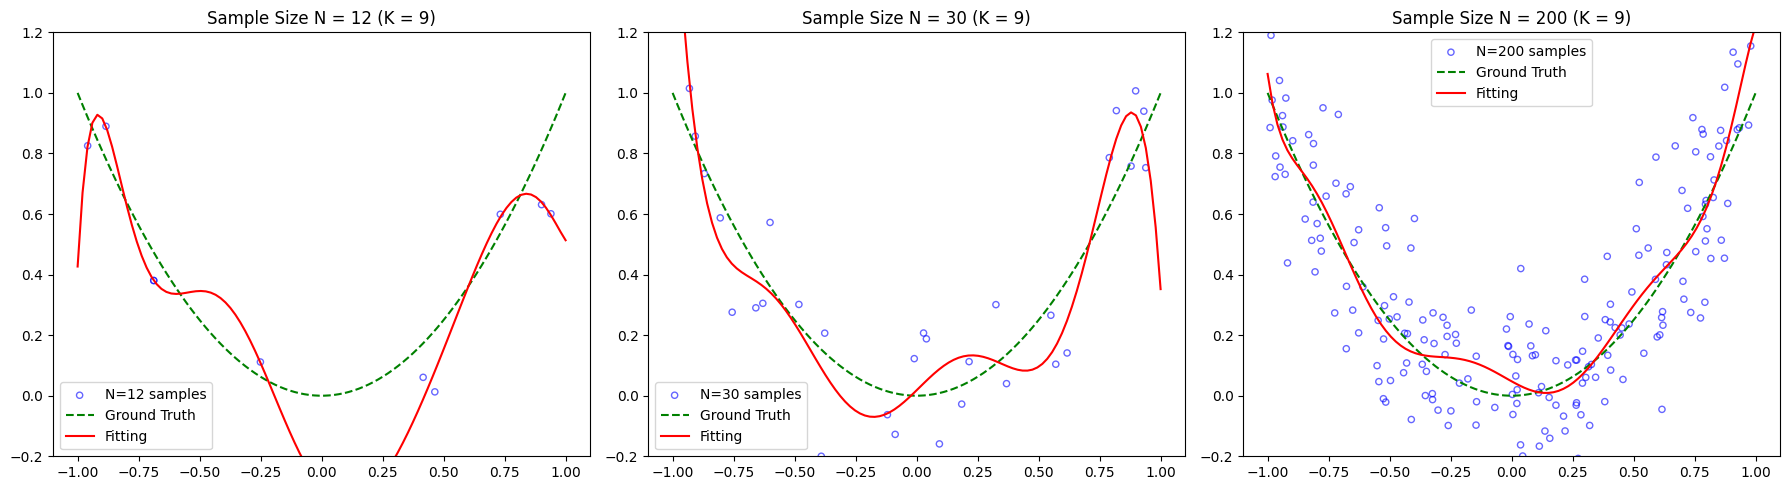

In [67]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def generate_data(n_samples, std=0.2):
    x = np.sort(np.random.uniform(-1, 1, n_samples))
    y = x ** 2 + np.random.normal(scale=std, size=x.shape)
    return x, y

# 固定多項式階數為 9 (原本在小樣本下會過擬合)
K = 9
# 設定不同的樣本數進行比較
sample_sizes = [12, 30, 200]

x_test = np.linspace(-1, 1, 100)
y_true = x_test ** 2

plt.figure(figsize=(18, 5))

for i, N in enumerate(sample_sizes):
    x, y = generate_data(N)

    # 構造設計矩陣與求解
    X = np.array([np.power(x, k) for k in range(K+1)]).transpose()
    XTX = X.transpose() @ X
    # 使用微小正則化確保矩陣運算穩定
    w = np.linalg.inv(XTX + np.eye(XTX.shape[0]) * 1e-6) @ (X.transpose() @ y)

    # 計算預測線
    y_predict = np.zeros_like(x_test)
    for j, wj in enumerate(w):
        y_predict += wj * np.power(x_test, j)

    # 繪圖
    plt.subplot(1, 3, i+1)
    plt.scatter(x, y, facecolor="none", edgecolor="b", s=20, alpha=0.6, label=f"N={N} samples")
    plt.plot(x_test, y_true, "g--", label="Ground Truth")
    plt.plot(x_test, y_predict, "r-", label="Fitting")
    plt.title(f"Sample Size N = {N} (K = {K})")
    plt.ylim(-0.2, 1.2)
    plt.legend()

plt.tight_layout()
plt.show()

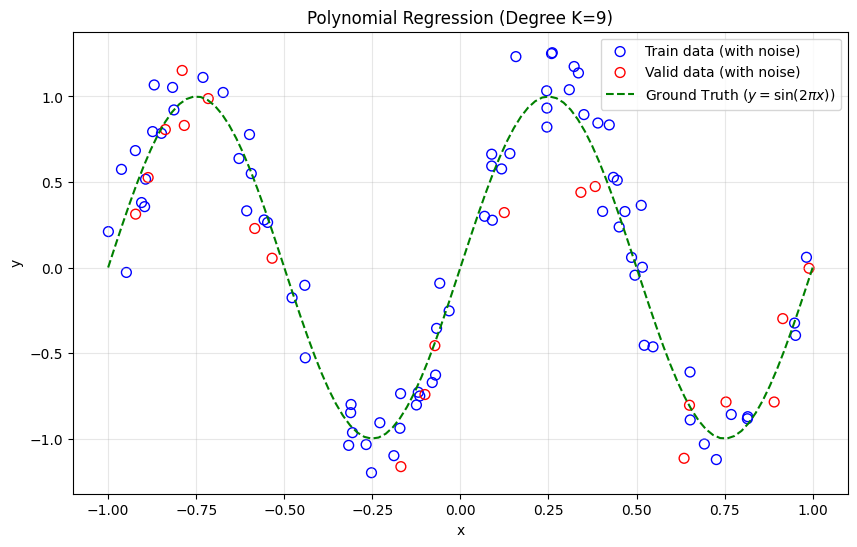

In [141]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 固定隨機種子，確保實驗的可重複性
# np.random.seed(564)

def sample(n_samples, std=0.2):
    """
    生成帶有高斯雜訊的二次函數樣本
    n_samples: 欲生成的樣本數量
    std: 雜訊標準差，控制數據偏離真實曲線的程度
    """
    # 在 -1 到 1 之間均勻採樣，並排序以利繪圖
    x = np.sort(np.random.uniform(-1, 1, n_samples))

    # 目標值
    # y = x ** 2 + np.random.normal(scale=std, size=x.shape) # 一般 y = y = x^2 + ε (ε ~ N(0, std^2))
    y = np.sin(2 * np.pi * x) + np.random.normal(scale=std, size=x.shape) # 正弦函數

    return x, y

def rmse(a, b):
    """計算均方根誤差 (Root Mean Square Error)"""
    return np.sqrt(np.mean(np.square(a - b)))

# 1. 訓練集 (Training Set)：
# 用來訓練模型的權重 (w)，讓模型學習正弦波的趨勢
x_train, y_train = sample(80)

# 2. 驗證集 (Validation Set)：
# 這是「開發中」的測試。用來挑選最適合的超參數（例如：決定多項式要用 3 次還是 9 次）
# 如果在訓練集表現好，但在這裡表現差，就代表發生了過擬合 (Overfitting)
x_valid, y_valid = sample(20)

# 3. 測試集 (Test Set)：
# 這是「最後」的期末考試。當模型架構與參數都決定後，
# 用完全沒看過的測試集來評估模型在現實世界中的真實表現
# x_test, y_test = sample(n_pts)

# 準備繪製「理論曲線」（真實函數，無雜訊）
x_true = np.linspace(-1, 1, 100)
# y_true = x_true ** 2
y_true = np.sin(2 * np.pi * x_true)

# 繪圖呈現
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Train data (with noise)") # 藍色採樣點
plt.scatter(x_valid, y_valid, facecolor="none", edgecolor="r", s=50, label="Valid data (with noise)") # 藍色採樣點
plt.plot(x_true, y_true, c="g", linestyle="--", label=r"Ground Truth ($y=\sin(2\pi x)$)")                         # 綠色虛線：原始函數

plt.title(f"Polynomial Regression (Degree K={K})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

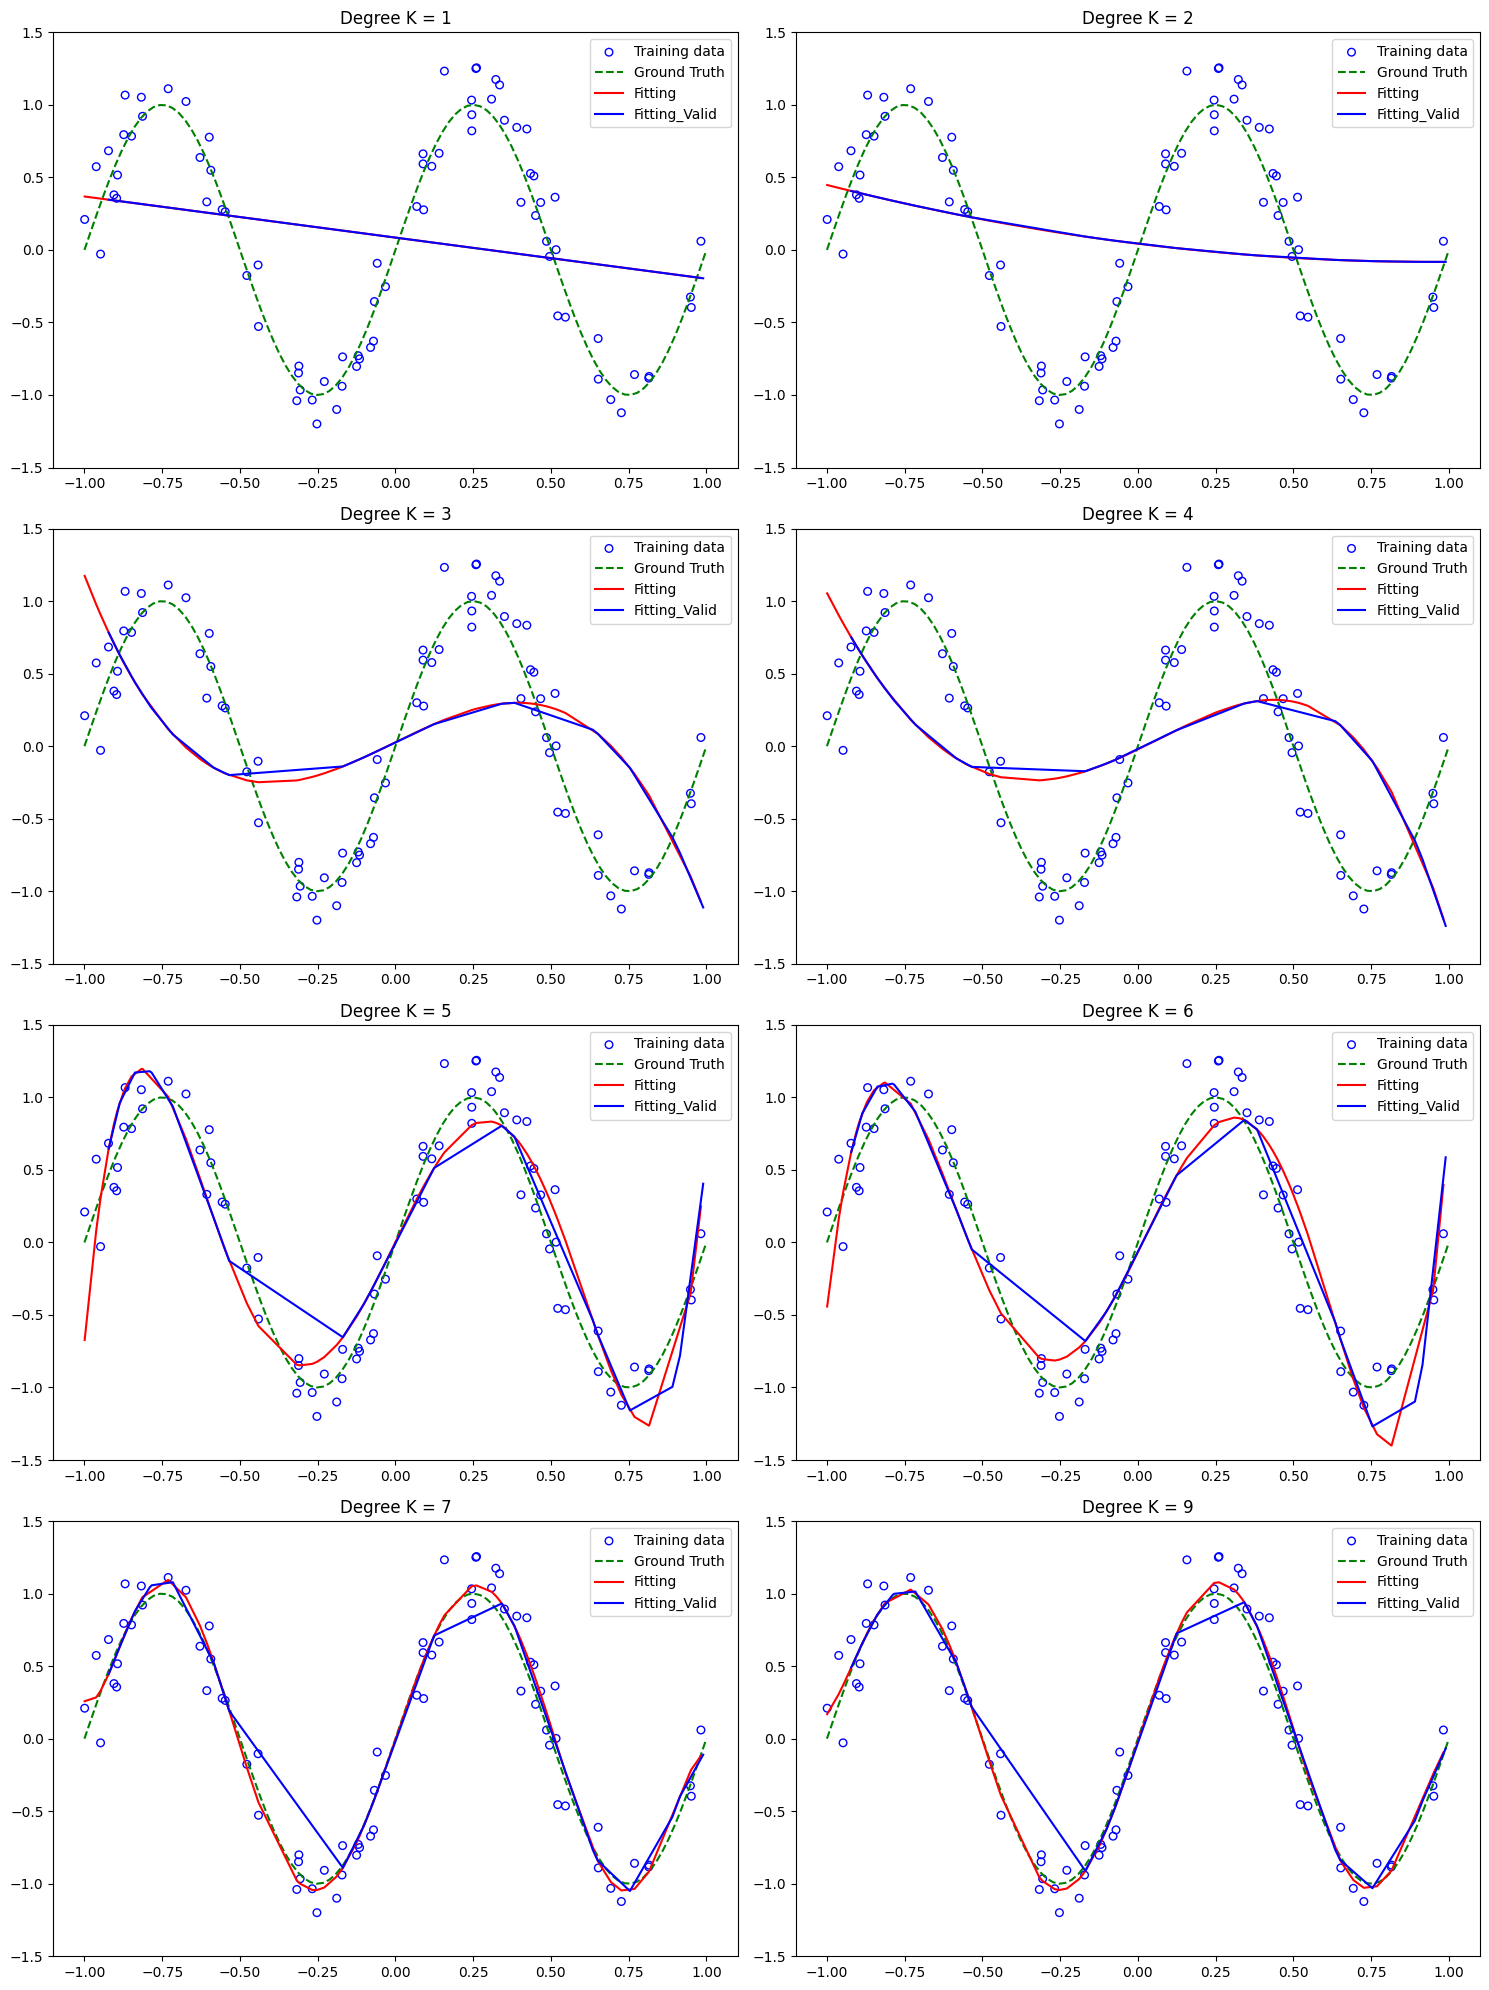

In [142]:
import numpy as np
import matplotlib.pyplot as plt

# 設定不同的多項式階數 (K)，從簡單的直線 (K=1) 到複雜的高階曲線 (K=9)
degrees = [1, 2, 3, 4, 5, 6, 7, 9]

# 初始化列表，用於儲存不同 K 值下的均方根誤差 (RMSE)
errors_train, errors_valid = [], []

# 設定繪圖佈局：共 8 張子圖（4列 x 2行）
plt.figure(figsize=(15, 20))

for i, K in enumerate(degrees):
    # --- 1. 構造訓練集的設計矩陣 (Design Matrix) ---
    # 生成多項式特徵：[x^0, x^1, ..., x^K]
    X = np.array([np.power(x_train, k) for k in range(K+1)]).transpose()

    # --- 2. 使用正規方程 (Normal Equation) 求解權重 w ---
    # 公式：w = (X^T * X)^-1 * X^T * y
    XTX = X.transpose() @ X
    # 加入 1e-6 (Ridge) 是為了防止矩陣不可逆（奇異矩陣），這是一種數值穩定手段
    w = np.linalg.inv(XTX + np.eye(XTX.shape[0]) * 1e-6) @ (X.transpose() @ y_train)

    # --- 3. 生成訓練集預測值 ---
    # 這裡手動遍歷 w 向量來計算預測結果 (y = Σ w_j * x^j)
    y_predict = np.zeros_like(x_train)
    for j, wj in enumerate(w):
        y_predict += wj * np.power(x_train, j)

    # --- 4. 計算訓練集誤差 (Training Error) ---
    # predict_train 使用矩陣乘法 X @ w 快速獲得結果
    predict_train = X @ w
    error_train = rmse(y_train, predict_train)

    # --- 5. 計算驗證集誤差 (Validation Error) ---
    # 注意：必須使用與訓練集相同的特徵階數 K
    X_valid = np.array([np.power(x_valid, k) for k in range(K+1)])
    X_valid = X_valid.transpose()
    # 核心：使用「訓練集學到的 w」去預測「從未見過的驗證集數據」
    predict_valid = X_valid @ w
    error_valid = rmse(y_valid, predict_valid)

    # 紀錄各個 K 值對應的誤差，以便後續分析誤差曲線
    errors_train.append(error_train)
    errors_valid.append(error_valid)

    # --- 繪圖呈現 ---
    plt.subplot(4, 2, i+1)
    # 畫出原始數據點（這裡的變數 x, y 需確保與訓練集一致）
    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=30, label="Training data")
    # 畫出綠色虛線：真實的函數 y = x^2
    plt.plot(x_true, y_true, "g--", label="Ground Truth")
    # 畫出紅色實線：模型在訓練集上的擬合曲線
    plt.plot(x_train, y_predict, "r-", label="Fitting")
    # 畫出藍色實線：模型在驗證集上的預測表現
    plt.plot(x_valid, predict_valid, "b-", label="Fitting_Valid")

    plt.title(f"Degree K = {K}")
    plt.ylim(-1.5, 1.5)
    plt.legend()

plt.tight_layout()
plt.show()

# 誤差對比曲線 (Learning Curve) 深度解析

**誤差對比曲線**（在特定情境下也稱為驗證曲線 Validation Curve）是機器學習中最重要的診斷工具之一。它透過觀察**訓練集 (Training Set)** 與 **驗證集 (Validation Set)** 誤差隨模型複雜度變化的趨勢，來判斷模型的健康狀況。

---

## 一、 核心用途：診斷模型狀態

透過兩條曲線的相對位置與走向，我們可以識別模型的三種主要狀態：

| 狀態 | 曲線特徵 | 診斷結果與策略 |
| --- | --- | --- |
| **欠擬合 (Underfitting)** | 訓練誤差與驗證誤差**同時居高不下**。 | 模型太簡單（High Bias）。應增加  階數或增加特徵。 |
| **理想狀態 (Sweet Spot)** | 兩條線都處於**低位且接近**。 | 模型成功捕捉規律。這是我們追求的最佳平衡點。 |
| **過擬合 (Overfitting)** | 訓練誤差極低，但驗證誤差**大幅上升**。 | 模型在鑽牛角尖（High Variance）。兩線間的缺口 (Gap) 即代表過擬合程度。 |

---

## 二、 尋找最佳模型複雜度 ( 值)

在多項式回歸實驗中，誤差曲線通常遵循以下規律：

1. **訓練集誤差 (Training Error)**：
* 隨著  階數增加，模型「記憶」能力變強，訓練誤差會**單調下降**。
* 即使  高到不合理，訓練誤差也會趨近於 0。


2. **驗證集誤差 (Validation Error)**：
* 呈現 **U 型曲線**。
* **下降段**：代表模型正在從「太笨」變得「剛好」。
* **轉折點**：驗證誤差的最低點，就是最佳的  值。
* **上升段**：代表模型開始過擬合，把雜訊當成規律。



---

## 三、 偏誤與變異的權衡 (Bias-Variance Tradeoff)

誤差對比曲線本質上是在視覺化「偏誤」與「變異」的拉鋸戰：

* **高偏誤 (High Bias)**：模型對數據的假設太強（例如硬要用直線畫曲線），對訓練數據不敏感。
* **高變異 (High Variance)**：模型對數據的微小波動太敏感，換一組訓練數據，模型就會長得完全不一樣。

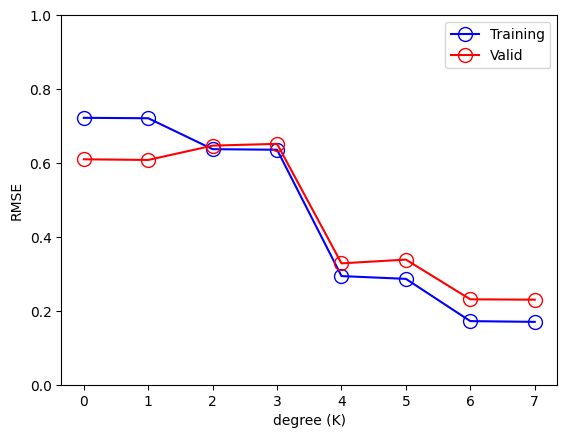

In [143]:
# --- 5. 繪製各種模型複雜度的誤差量曲線 ---
plt.plot(errors_train, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(errors_valid, 'o-', mfc="none", mec="r", ms=10, c="r", label="Valid")
plt.legend()
plt.xlabel("degree (K)")
plt.ylabel("RMSE")
plt.ylim(0, 1) # 限制 y 軸範圍以利觀察
plt.show()

# 水壩出水量範例

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

def linear_regression_vec(X, y, alpha, num_iters, gamma=0.8, epsilon=1e-8):
    """
    使用向量化的梯度下降法（含動量項）訓練線性回歸模型
    X: 特徵矩陣, y: 標籤向量, alpha: 學習率, num_iters: 迭代次數
    gamma: 動量係數, epsilon: 停止迭代的梯度閾值
    """
    history = []          # 紀錄每次迭代後的參數 w

    # 矩陣增廣：在 X 的最左側添加一列全為 1 的向量，對應偏置項 (bias/intercept)
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    num_features = X.shape[1]

    # 初始化動量向量 v 與權重向量 w
    v = np.zeros_like(num_features)
    w = np.zeros(num_features)

    for n in range(num_iters):
        # 計算預測值：h(x) = X * w
        predictions = X @ w

        # 計算誤差向量
        errors = predictions - y

        # 計算梯度：(1/m) * X^T * (Xw - y)
        gradient = X.transpose() @ errors / len(y)

        # 檢查梯度最大值是否小於閾值，若是則提前停止迭代
        if np.max(np.abs(gradient)) < epsilon:
            # print("gradient is small enough!")
            # print("iterated num is :", n)
            break

        # 更新動量 v：結合前一次的速度與目前的梯度
        v = gamma * v + alpha * gradient

        # 更新參數 w：減去動量項
        w = w - v

        # 紀錄當前權重
        history.append(w)

    return history

def loss(w, X, y):
    """
    計算給定權重 w 下的均方誤差 (MSE) 損失
    """
    # 同樣需要對輸入的 X 進行增廣（補 1）以符合 w 的維度
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    # 計算預測值與誤差
    predictions = X @ w
    errors = predictions - y

    # 回傳損失函數值 J(w) = (1/2m) * sum(errors^2)
    return (errors**2).mean() / 2

def learning_curves_trainSize(X_train, y_train, X_val, y_val, alpha=0.3, iterations=1000):
    """
    繪製學習曲線，觀察不同訓練樣本數量下的訓練誤差與驗證誤差
    """
    train_err = np.zeros(len(y_train))
    valid_err = np.zeros(len(y_train))

    # 循環增加訓練集的規模，從 1 個樣本到全部樣本
    for i in range(len(y_train)):
        # 僅使用前 i+1 個樣本進行模型訓練
        w_history = linear_regression_vec(X_train[0:i + 1, :], y_train[0:i + 1], alpha, iterations)

        # 取得最後一次迭代的權重
        w = w_history[-1]

        # 計算該權重在「當前訓練子集」上的誤差
        train_err[i] = loss(w, X_train[0:i + 1, :], y_train[0:i + 1])

        # 計算該權重在「完整驗證集」上的誤差
        valid_err[i] = loss(w, X_val, y_val)

    # 繪製訓練誤差（紅線）與驗證誤差（藍線）
    plt.plot(range(1, len(y_train) + 1), train_err, c="r", linewidth=2)
    plt.plot(range(1, len(y_train) + 1), valid_err, c="b", linewidth=2)
    plt.xlabel("number of training examples", fontsize=14)
    plt.ylabel("error", fontsize=14)
    plt.legend(["training", "validation"], loc="best")

    # 設定坐標軸顯示範圍，並加入 offset 緩衝空間
    max_err = np.max(np.array([np.max(train_err), np.max(valid_err)]))
    min_err = np.min(np.array([np.min(train_err), np.min(valid_err)]))
    offset = (max_err - min_err) / 10
    plt.axis([1, len(y_train) + 1, min_err - offset, max_err + offset])
    plt.grid()

Degree 1 - Train shape: (12, 1)
Degree 1 - Val shape: (21, 1)


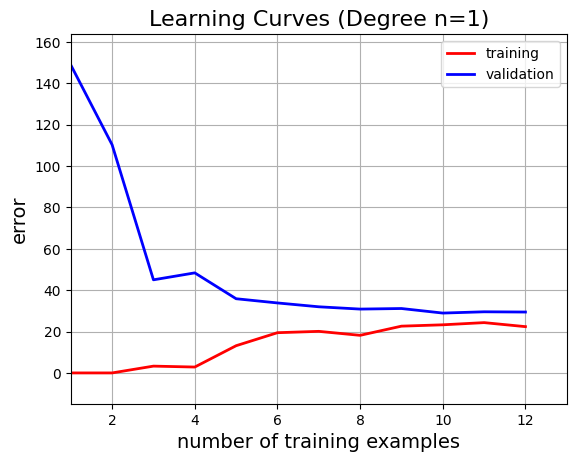

Degree 3 - Train shape: (12, 3)
Degree 3 - Val shape: (21, 3)


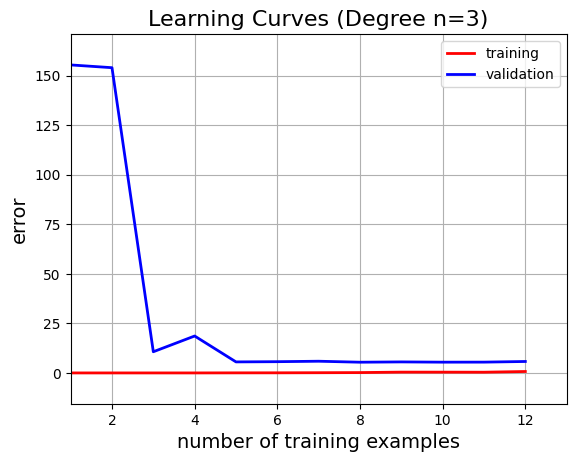

Degree 9 - Train shape: (12, 9)
Degree 9 - Val shape: (21, 9)


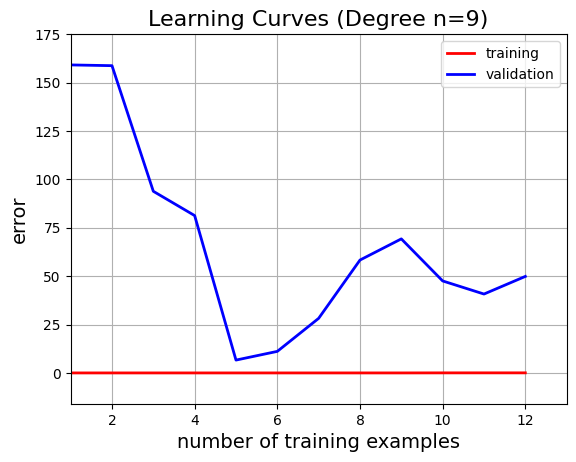

In [147]:
# 讀取 .mat 格式的資料集（通常用於 Andrew Ng 的機器學習課程資料）
dataset = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/water.mat")
x_train = dataset["X"]
x_val = dataset["Xval"]
x_test = dataset["Xtest"]

# 將目標變量 y 壓縮成一維陣列，方便後續向量化運算
y_train = dataset["y"].squeeze()
y_val = dataset["yval"].squeeze()
y_test = dataset["ytest"].squeeze()

# 定義不同模型複雜度下的超參數
alphas = [0.3, 0.3, 0.3]        # 學習率
iterations = [100000, 100000, 100000]  # 迭代次數

# 針對不同的多項式階數 n (1, 3, 9) 進行循環
for i, n in enumerate([1, 3, 9]):
    # --- 1. 特徵構造：生成多項式特徵 [x^1, x^2, ..., x^n] ---
    x_train_n = np.hstack(tuple(x_train**(k+1) for k in range(n)))

    # --- 2. 特徵標準化 (Standardization) ---
    # 計算訓練集的均值與標準差（ddof=1 代表樣本標準差）
    train_means = x_train_n.mean(axis=0)
    train_stdevs = np.std(x_train_n, axis=0, ddof=1)

    # 對訓練集進行 Z-score 歸一化
    x_train_n = (x_train_n - train_means) / train_stdevs

    # --- 3. 處理驗證集特徵 ---
    x_val_n = np.hstack(tuple(x_val**(k+1) for k in range(n)))
    # 注意：驗證集必須使用「訓練集」的均值與標準差來縮放，以確保數據分佈一致
    x_val_n = (x_val_n - train_means) / train_stdevs

    # --- 4. 繪製與診斷 ---
    plt.title(f"Learning Curves (Degree n={n})", fontsize=16)
    print(f"Degree {n} - Train shape: {x_train_n.shape}")
    print(f"Degree {n} - Val shape: {x_val_n.shape}")

    # 呼叫先前定義的函數，繪製隨訓練樣本數增加時的誤差變化圖
    learning_curves_trainSize(x_train_n, y_train, x_val_n, y_val, alphas[i], iterations[i])
    plt.show()